# Model Selection, Underfitting, and Overfitting

Explore these concepts interactively
by fitting polynomials to data

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Use the following cubic polynomial to generate the labels
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Take a look at the first 2 samples

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.2614],
         [0.1337]]),
 tensor([[1.0000e+00, 2.6139e-01, 3.4163e-02, 2.9767e-03, 1.9452e-04, 1.0169e-05,
          4.4303e-07, 1.6544e-08, 5.4055e-10, 1.5699e-11, 4.1037e-13, 9.7517e-15,
          2.1242e-16, 4.2712e-18, 7.9746e-20, 1.3897e-21, 2.2703e-23, 3.4909e-25,
          5.0694e-27, 6.9742e-29],
         [1.0000e+00, 1.3373e-01, 8.9420e-03, 3.9861e-04, 1.3327e-05, 3.5644e-07,
          7.9445e-09, 1.5178e-10, 2.5371e-12, 3.7699e-14, 5.0416e-16, 6.1293e-18,
          6.8306e-20, 7.0267e-22, 6.7121e-24, 5.9841e-26, 5.0016e-28, 3.9345e-30,
          2.9232e-32, 2.0575e-34]]),
 tensor([5.1513, 5.1530]))

Implement a function to evaluate the loss on a given dataset

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

Define the training function

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

Third-Order Polynomial Function Fitting (Normal)

weight: [[ 5.0126886  1.2544692 -3.408528   5.506672 ]]


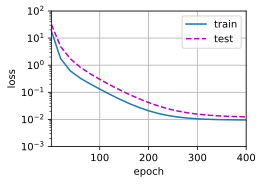

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Linear Function Fitting (Underfitting)

weight: [[3.4968083 3.409089 ]]


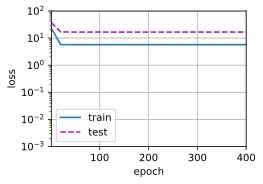

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Higher-Order Polynomial Function Fitting  (Overfitting)

weight: [[ 4.9923630e+00  1.2916508e+00 -3.3051541e+00  5.1985683e+00
  -3.3861870e-01  1.2398092e+00  2.0640171e-01  2.6043344e-01
  -4.8353344e-02  1.6823786e-01 -9.1919936e-02  6.4599946e-02
  -1.9801045e-02 -5.0019003e-02 -2.0456594e-01 -1.4816639e-03
   2.4789847e-02 -3.4502655e-02 -4.2566311e-02 -1.7346767e-01]]


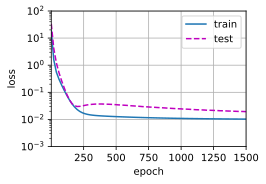

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)